In [100]:
import geopandas as gdp
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.dates as mdates
from collections import Counter

DATA_DIR = 'Data/'

# Loading the Data

In [101]:
def get_offsets(header_lines):
    """
    Extracts offset and postseismic decay information from the header lines of a GNSS file.

    This function parses header lines starting with '#' to capture metadata about coseismic and 
    non-coseismic offsets as well as postseismic decays for the north (N), east (E), and up (U) 
    components. It uses regular expressions to identify and extract offset and decay data, 
    organizing them into a structured dictionary.

    Parameters:
    - header_lines (list of str): Lines from the file that contain metadata and comments, 
                                  typically starting with '#'.

    Returns:
    - components (dict): A dictionary structured as follows:
        - Keys: 'n', 'e', and 'u' representing the north, east, and up components.
        - Values: Each key maps to a dictionary with two lists:
            - 'offsets': A list of dictionaries containing offset information:
                - 'value': Magnitude of the offset (float, in mm).
                - 'error': Associated error margin (float, in mm).
                - 'date': Date of the offset (str, in 'YYYY-MM-DD' format).
                - 'coseismic': A boolean indicating if the offset is coseismic (True) or not (False).
            - 'ps_decays': A list of dictionaries containing postseismic decay information:
                - 'value': Decay magnitude (float, in mm).
                - 'error': Associated error margin (float, in mm).
                - 'tau': Time constant of the decay (int, in days).
                - 'date': Date of the decay measurement (str, in 'YYYY-MM-DD' format).
                - 'type': Decay type, either 'logarithmic' or 'exponential'.
    """
    
    offset_pattern = re.compile(r"#\s*(\*?)\s*offset\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    ps_decay_pattern = re.compile(r'#!?\s*ps decay\s+\d:\s*(-?\d+\.\d+)\s+\+/-\s+(\d+\.\d+)\s+mm\s+\((\d{4}-\d{2}-\d{2})\s+\[(\d{4}\.\d+)\]\);\s*tau:\s*(\d+)\s+days')
    component_pattern = re.compile(r"#\s+([neu])\s+component")

    components = {'n': {'offsets': [], 'ps_decays': []}, 'e': {'offsets': [], 'ps_decays': []}, 'u': {'offsets': [], 'ps_decays': []}}
    current_component = None

    for line in header_lines:
        comp_match = component_pattern.match(line)
        if comp_match:
            current_component = comp_match.group(1)
            continue

        offset_match = offset_pattern.match(line)
        if offset_match and current_component:
            coseismic = bool(offset_match.group(1))  # True if * present, meaning coseismic
            offset_value = float(offset_match.group(2))
            offset_error = float(offset_match.group(3))
            offset_date = offset_match.group(4)
            components[current_component]['offsets'].append({
                'value': offset_value,
                'error': offset_error,
                'date': offset_date,
                'coseismic': coseismic
            })

        ps_decay_match = ps_decay_pattern.match(line)
        if ps_decay_match and current_component:
            decay_value = float(ps_decay_match.group(1))
            decay_error = float(ps_decay_match.group(2))
            decay_date = ps_decay_match.group(3)
            tau = int(ps_decay_match.group(5))
            # Determine decay type based on the presence of '!'
            decay_type = 'logarithmic' if '!' in line else 'exponential'
            components[current_component]['ps_decays'].append({
                'value': decay_value,
                'error': decay_error,
                'tau': tau,
                'date': decay_date,
                'type': decay_type
            })

    return components

def read_file(filename):
    """
    Reads a GNSS file, extracting header metadata and time-series data into a pandas DataFrame.

    The function processes GNSS files containing metadata (in header lines starting with '#') and 
    time-series data. The header metadata includes station geometry (latitude, longitude, height) 
    and offsets/decay parameters for the N, E, U components. The time-series data includes 
    displacement measurements, uncertainties, and correlations.

    Parameters:
    - filename (str): The path to the GNSS file to be read.

    Returns:
    - data (pandas.DataFrame): A DataFrame containing the time-series GNSS data with columns:
        - 'N', 'E', 'U': Displacement components (float, in mm).
        - 'N sig', 'E sig', 'U sig': Uncertainties for the components (float, in mm).
        - 'CorrNE', 'CorrNU', 'CorrEU': Correlation coefficients between components (float).
      The DataFrame is indexed by the 'Date' column (datetime). 

      Additional metadata is stored in the DataFrame's attributes:
        - `data.attrs['geometry']`: A `shapely.geometry.Point` object representing latitude and longitude.
        - `data.attrs['height']`: The station height (float, in meters).
        - `data.attrs['offsets']`: A dictionary containing coseismic and postseismic offset/decay information.
        - `data.name`: The station name extracted from the filename.
    """
    
    with open(DATA_DIR+filename, 'r') as file:
        lines = file.readlines()

    header_lines = [line for line in lines if line.startswith('#')]
    if header_lines:
        column_names = re.split(r'\s{2,}', header_lines[-1].lstrip('#').strip())
    else:
        column_names = []
        
    data_lines = []
    for line in lines:
        if not line.startswith('#'):
            parts = line.strip().split()
            # Check if the number of parts matches the expected number of columns
            if len(parts) < len(column_names):
                # Add None for missing values
                parts.extend([None] * (len(column_names) - len(parts)))
            data_lines.append(parts)

    data = pd.DataFrame(data_lines)
    data.columns = column_names
    
    # Extracts latitude, longitude and height
    pattern = r'Latitude\(DD\)\s*:\s*(-?\d+\.\d+)|East Longitude\(DD\)\s*:\s*(-?\d+\.\d+)|Height\s*\(M\)\s*:\s*(-?\d+\.\d+)'
    matches = re.findall(pattern, ' '.join(header_lines))
    geom = Point(float(matches[1][1]), float(matches[0][0]))
    
    offsets = get_offsets(header_lines)

    data['Date'] = pd.to_datetime(data['Yr'].astype(str) + data['DayOfYr'].astype(str), format='%Y%j')
    data.set_index('Date', inplace=True)
    data.drop(['Dec Yr', 'Yr', 'DayOfYr', 'Chi-Squared'], axis=1, inplace=True)
    cols = ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']
    data[cols] = data[cols].astype(float)
    
    data.name = filename.replace("RawTrend.neu", "")
    data.attrs['geometry'] = geom
    data.attrs['height'] = float(matches[2][2])
    data.attrs['offsets'] = offsets
    
    return data

In [102]:
def organize_files():
    """
    Reads all data files from the specified directory DATA_DIR and organizes them into a list of DataFrames.

    Parameters:
    - None

    Returns:
    - dfs (list): A list of DataFrames, each representing a dataset read from a file in the directory.
    """

    dfs = []
    dir = Path(DATA_DIR)
    for file_path in dir.iterdir():
        if file_path.is_file():
            dfs.append(read_file(file_path.name))
    return dfs

In [103]:
dfs = organize_files()

# First Plots

In [104]:
# Define standard font sizes and other plotting parameters for consistency
legend_fontsize = 16
label_fontsize = 20
title_fontsize = 22
tick_fontsize = 14
dpi_setting = 300
plot_size = (12, 8)
subplot_size = (14, 12)

In [105]:
def plot_stations(dfs):
    """
    Plots the geographic locations of stations on a map using their geometries.

    This function creates a GeoDataFrame from the geometry attributes of the provided dataframes, 
    reprojects it to the Web Mercator coordinate reference system (EPSG:3857), 
    and visualizes the station locations on a map using OpenStreetMap as the basemap. 

    Parameters:
    - dfs (list): A list of dataframes, each containing a 'geometry' attribute that represents the geographic location of a station.

    Returns:
    - None
    """

    gdf = gdp.GeoDataFrame(geometry=[df.attrs['geometry'] for df in dfs])
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=3857, inplace=True)
    
    fig, ax = plt.subplots(figsize=subplot_size, dpi=dpi_setting)
    gdf.plot(marker='o', color='darkblue', markersize=10, ax=ax)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title('Station Locations', fontsize=title_fontsize)
    ax.set_xlabel('Longitude (EPSG:3857)', fontsize=label_fontsize)
    ax.set_ylabel('Latitude (EPSG:3857)', fontsize=label_fontsize)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    ax.tick_params(axis='both', labelsize=tick_fontsize)
    plt.tight_layout()
    plt.show()

In [106]:
def plot_logarithmic_decay(ax, decay, tau, value):
    """
    Plots a logarithmic decay curve starting from the specified decay date.

    Parameters:
    - ax (matplotlib.axes.Axes): The axis object to plot the decay curve on.
    - decay (dict): A dictionary containing the 'date' key representing the start date of the decay.
    - tau (float): The decay constant that controls the rate of logarithmic decay.
    - value (float): The initial value to scale the decay curve.

    Returns:
    - line (matplotlib.lines.Line2D): The plot line object representing the logarithmic decay curve.
    """
    
    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    decay_curve = value * np.log(1 + time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='-', color='y')
    return line

def plot_exponential_decay(ax, decay, tau, value):
    """
    Plots an exponential decay curve starting from the specified decay date.

    Parameters:
    - ax (matplotlib.axes.Axes): The axis object to plot the decay curve on.
    - decay (dict): A dictionary containing the 'date' key representing the start date of the decay.
    - tau (float): The decay constant that controls the rate of exponential decay.
    - value (float): The initial value to scale the decay curve.

    Returns:
    - line (matplotlib.lines.Line2D): The plot line object representing the exponential decay curve.
    """

    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    decay_curve = value * np.exp(-time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='--', color='g')
    return line

In [107]:
def plot_time_series(df_org, cols, titles, offset_date=None, zoom_days=300, xlabel='Date', ylabel='Data', 
                     second_ylabel='Secondary Data', error_scale=1, plot_decays=True):
    """
    Plots multiple time series and optionally overlays offsets and decays.

    This function creates subplots for a set of time series columns, optionally zooming in around a specified offset_date. 
    It supports plotting main data, along with offsets (coseismic and non-coseismic) and decay curves (logarithmic and exponential). 
    The decays are plotted as additional curves if the plot_decays flag is enabled. 
    Secondary y-axes are used for displaying the offsets, and error bars are applied to the offset values. 

    Parameters:
    - df_org (pd.DataFrame): The original dataframe containing the time series data to plot.
    - cols (list): A list of column names to be plotted.
    - titles (list): A list of titles for each subplot corresponding to the columns in cols.
    - offset_date (str or None): The date to zoom around. If None, the full time range is plotted.
    - zoom_days (int): The number of days before and after the offset_date to zoom into.
    - xlabel (str): Label for the x-axis (default is 'Date').
    - ylabel (str): Label for the primary y-axis (default is 'Data').
    - second_ylabel (str or None): Label for the secondary y-axis (default is 'Secondary Data').
    - error_scale (float): Scaling factor for the error bars of the offsets (default is 1).
    - plot_decays (bool): Flag to control whether decay curves should be plotted (default is True).

    Returns:
    - None
    """
    
    fig, axs = plt.subplots(1, len(cols), figsize=subplot_size, sharey=False)
    df = df_org.copy()
    df.name = df_org.name

    for col in cols:
        if col not in ['CorrNE', 'CorrNU', 'CorrEU']:
            df[col] *= 1000

    # If an offset_date is provided, zoom in around it; otherwise, plot the whole range
    if offset_date:
        offset_date = pd.to_datetime(offset_date)
        start_date = offset_date - pd.Timedelta(days=zoom_days)
        end_date = offset_date + pd.Timedelta(days=zoom_days)
        df_zoomed = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    else:
        df_zoomed = df
        
    plt.suptitle(f'Station: {df.name}', fontsize=24)
    df_zoomed[cols].plot(ax=axs, subplots=True, legend=False, style='o', ylabel=ylabel, xlabel=xlabel, color='b', label='_nolegend_')

    for ind, ax in enumerate(axs): 
        ax.set_title(f'{titles[ind]}', fontsize=title_fontsize)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            
        # Limit the number of x-ticks to avoid crowding
        if offset_date:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
        else:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

        # Set x-axis format for dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d' if offset_date else '%Y'))
        
        ax.set_xlabel(xlabel, fontsize=label_fontsize)
        ax.set_ylabel(ylabel, fontsize=label_fontsize)

    components = ['n', 'e', 'u']
    offsets_data = df.attrs['offsets']

    # Create secondary y-axes for offsets
    secondary_y_axes = [ax.twinx() for ax in axs]

    handles = [] 
    labels = []

    for i, component in enumerate(components):
        comp_offsets = offsets_data[component]['offsets']
        comp_decays = offsets_data[component].get('ps_decays', [])

        # Plot offsets with potentially scaled error bars
        for offset in comp_offsets:
            linestyle = '-' if offset.get('coseismic', False) else '--'
            color = 'r' if linestyle == '-' else 'orange'
            label = ('Coseismic Offset' if offset.get('coseismic', False) else 'Non-coseismic Offset')
            marker = 'o' if linestyle == '-' else 's'
            
            secondary_y_axes[i].errorbar(
                pd.to_datetime(offset['date']),
                offset['value'],
                yerr=offset['error'] * error_scale,
                fmt=marker,
                markersize=10,
                capsize=5,
                capthick=2,
                color=color,
                label=label
            )
            secondary_y_axes[i].tick_params(labelsize=tick_fontsize)
            
            if label not in labels:
                handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor=color))
                labels.append(label)

        if plot_decays:
            for decay in comp_decays:
                decay_type = decay['type']
                tau = decay['tau']
                value = decay['value']

                if decay_type == 'logarithmic':
                    line = plot_logarithmic_decay(axs[i], decay, tau, value)
                    if 'Logarithmic Decay' not in labels:
                        handles.append(line) 
                        labels.append('Logarithmic Decay')

                elif decay_type == 'exponential':
                    line = plot_exponential_decay(axs[i], decay, tau, value)
                    if 'Exponential Decay' not in labels:
                        handles.append(line)
                        labels.append('Exponential Decay')

        if i == 0:
            axs[i].set_ylabel(ylabel, fontsize=label_fontsize)
        else:
            axs[i].set_ylabel('')
        if i == len(cols)-1 and second_ylabel:
            secondary_y_axes[i].set_ylabel(second_ylabel, fontsize=label_fontsize)
        if offset_date:
            axs[i].set_xlim(start_date, end_date)
        axs[i].tick_params(axis='both', labelsize=tick_fontsize)

    if handles:
        axs[0].legend(handles, labels, loc='upper left', fontsize=legend_fontsize)

    plt.tight_layout()
    plt.show()

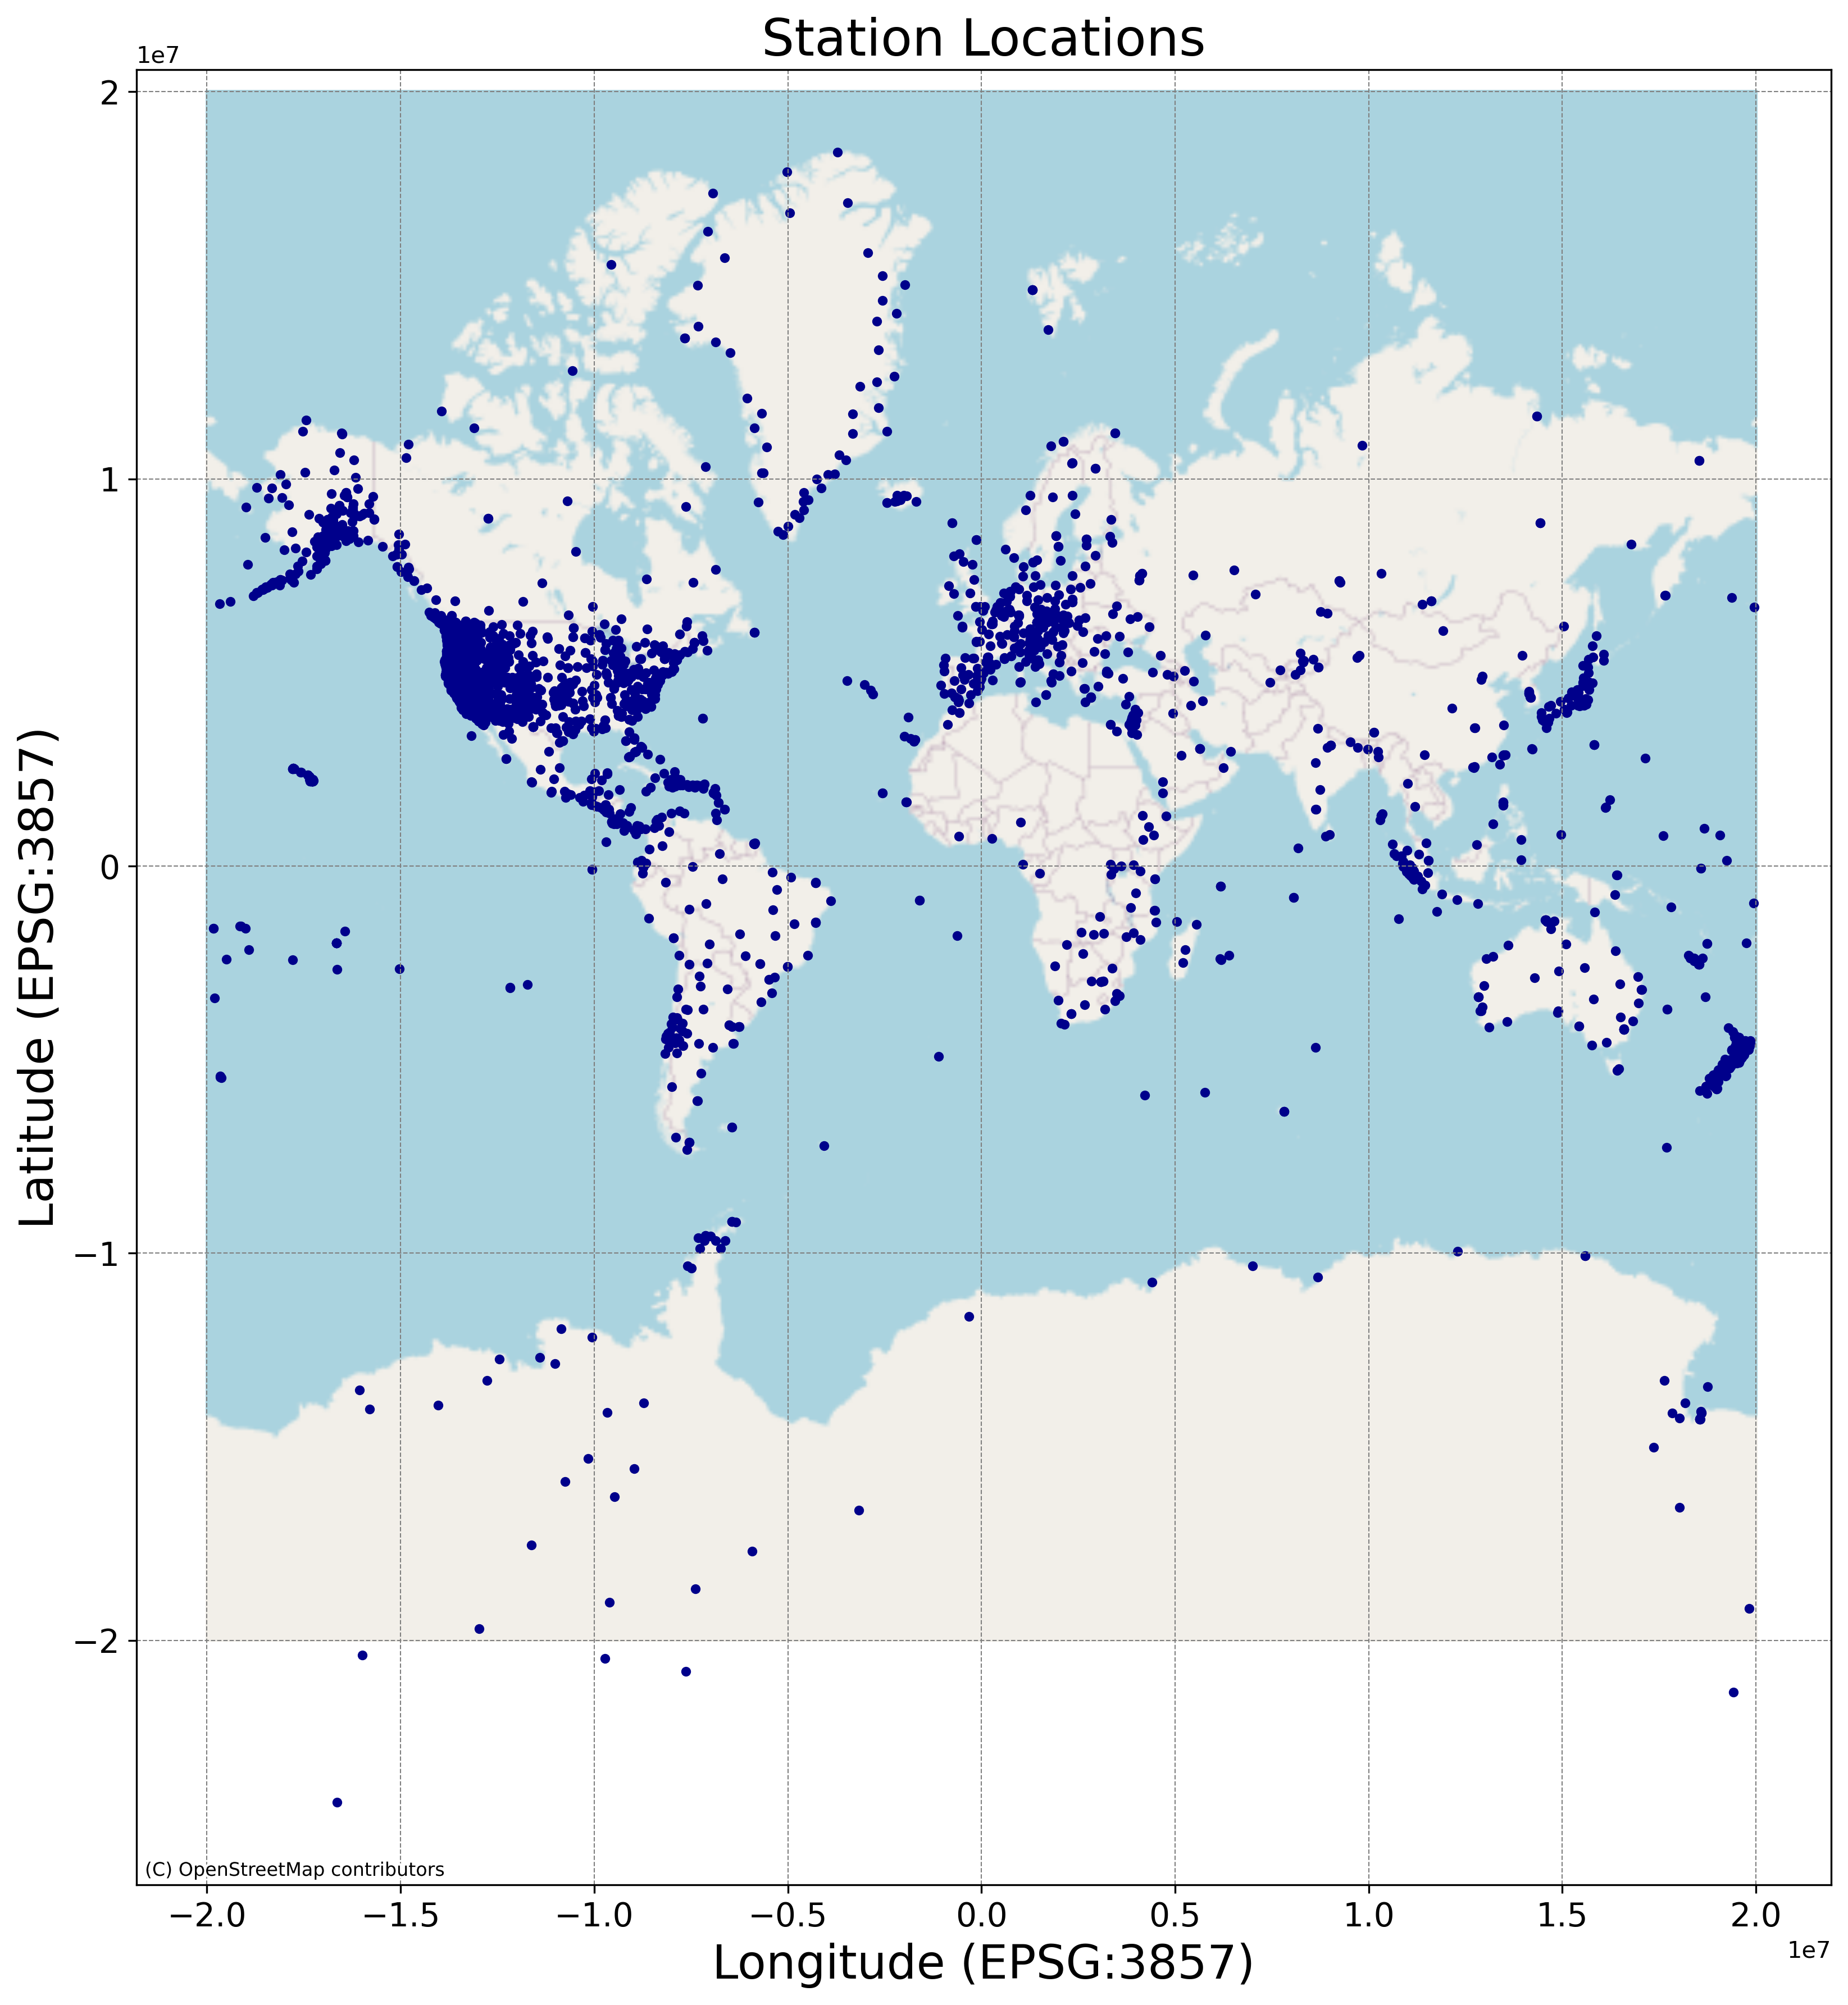

In [108]:
# All stations before cleaning
plot_stations(dfs)

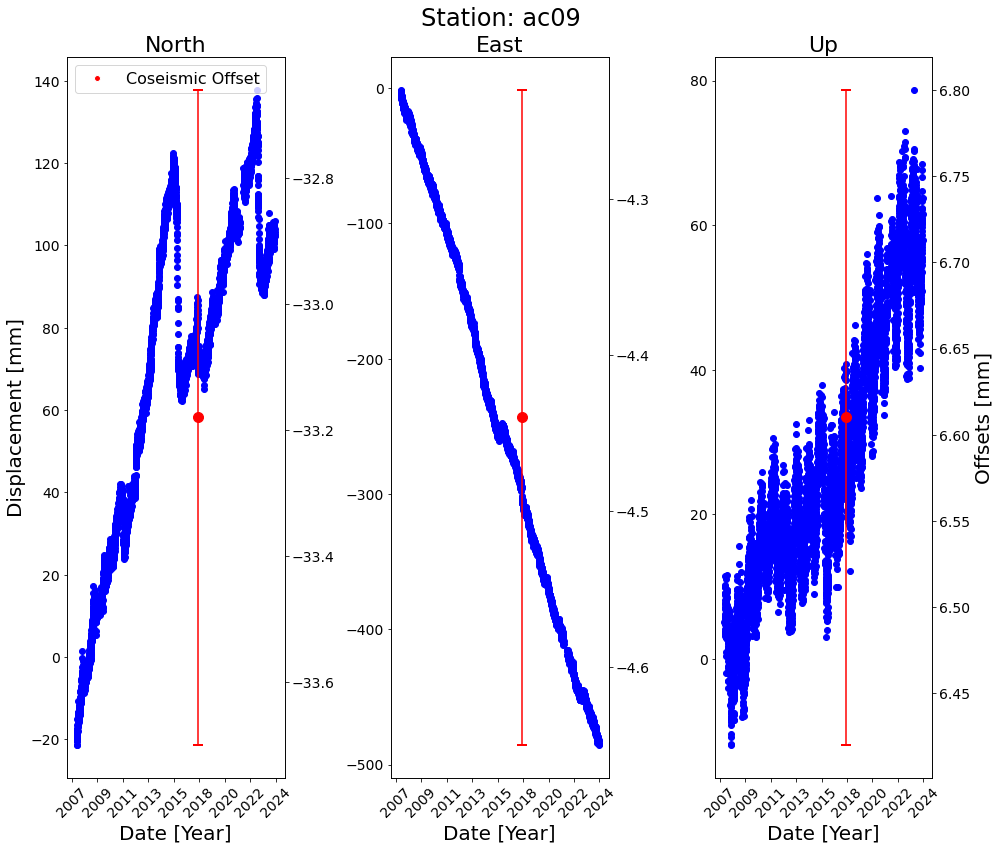

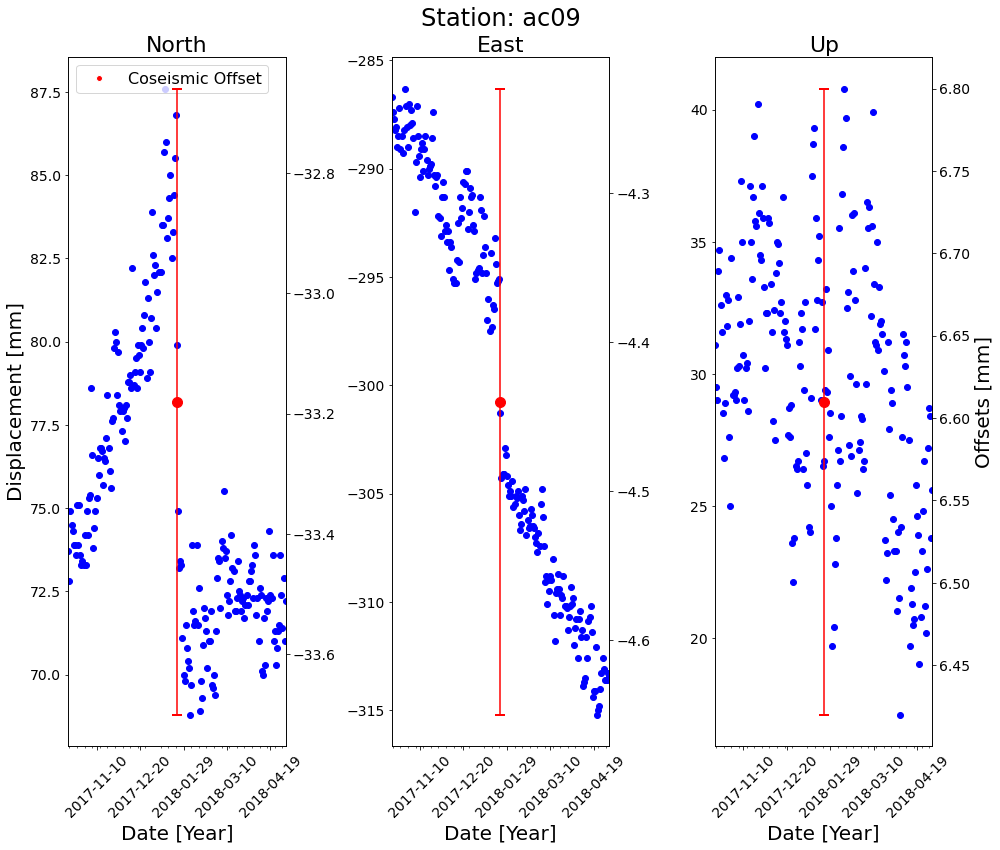

In [109]:
# Exemplary use for a station:
df = dfs[51]

# Displacements
plot_time_series(df, ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [mm]', xlabel='Date [Year]', second_ylabel='Offsets [mm]')
plot_time_series(df, ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [mm]', xlabel='Date [Year]', second_ylabel='Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

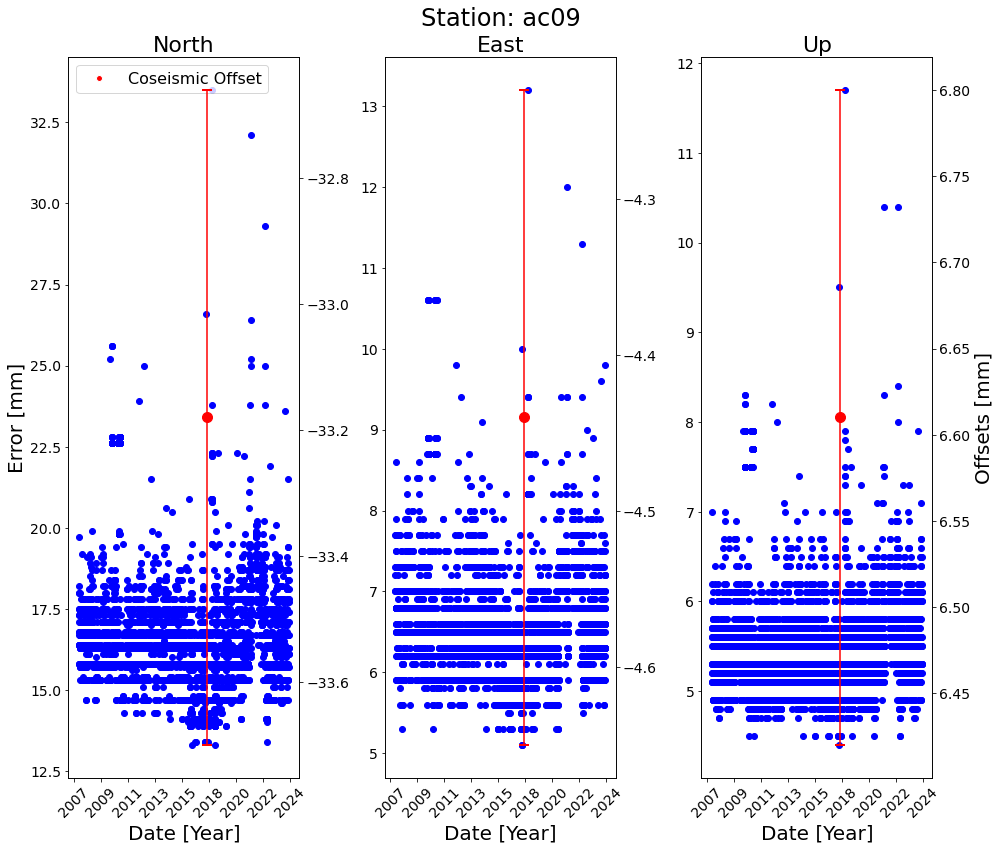

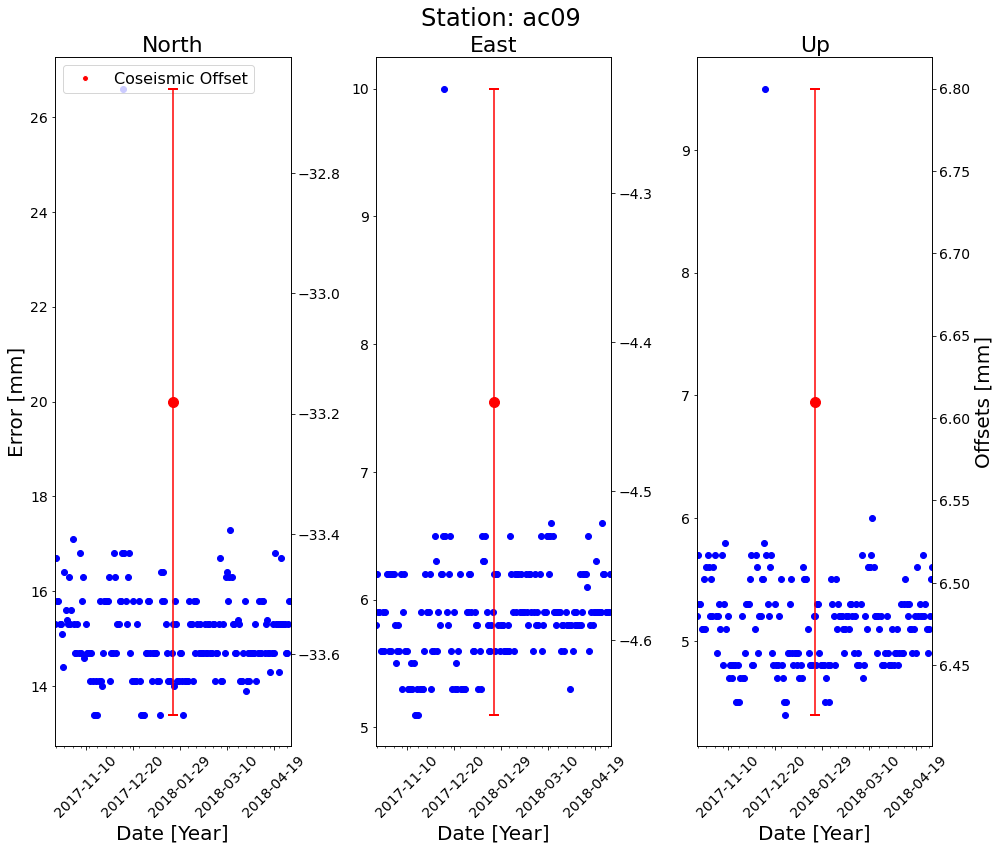

In [110]:
# Errors
plot_time_series(df, ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [mm]', xlabel='Date [Year]', second_ylabel= 'Offsets [mm]', plot_decays=False)
plot_time_series(df, ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [mm]', xlabel='Date [Year]', second_ylabel= 'Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

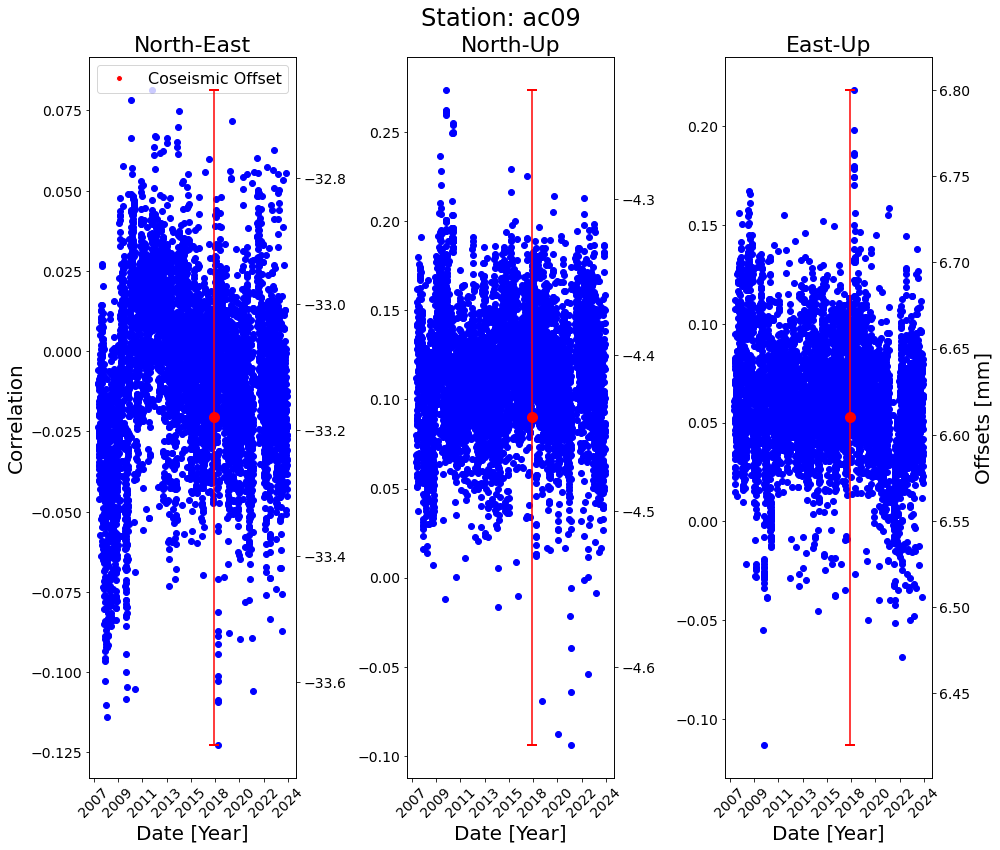

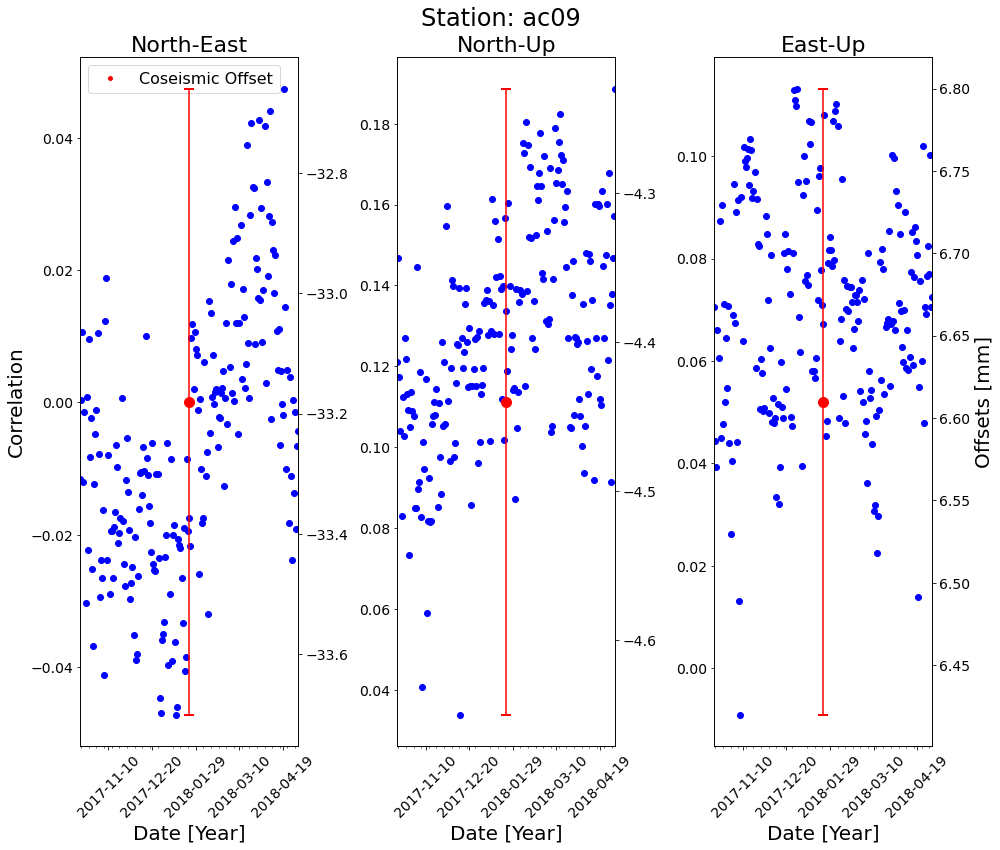

In [111]:
# Correlations
plot_time_series(df, ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-East', 'North-Up', 'East-Up'], ylabel='Correlation', xlabel='Date [Year]', second_ylabel='Offsets [mm]', plot_decays=False)
plot_time_series(df, ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-East', 'North-Up', 'East-Up'], ylabel='Correlation', xlabel='Date [Year]', second_ylabel='Offsets [mm]', offset_date=df.attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)

# First Statistics

The total number of stations before cleaning is: 3827
Total number of offsets for n component: 4252
Total number of decays for n component: 1049


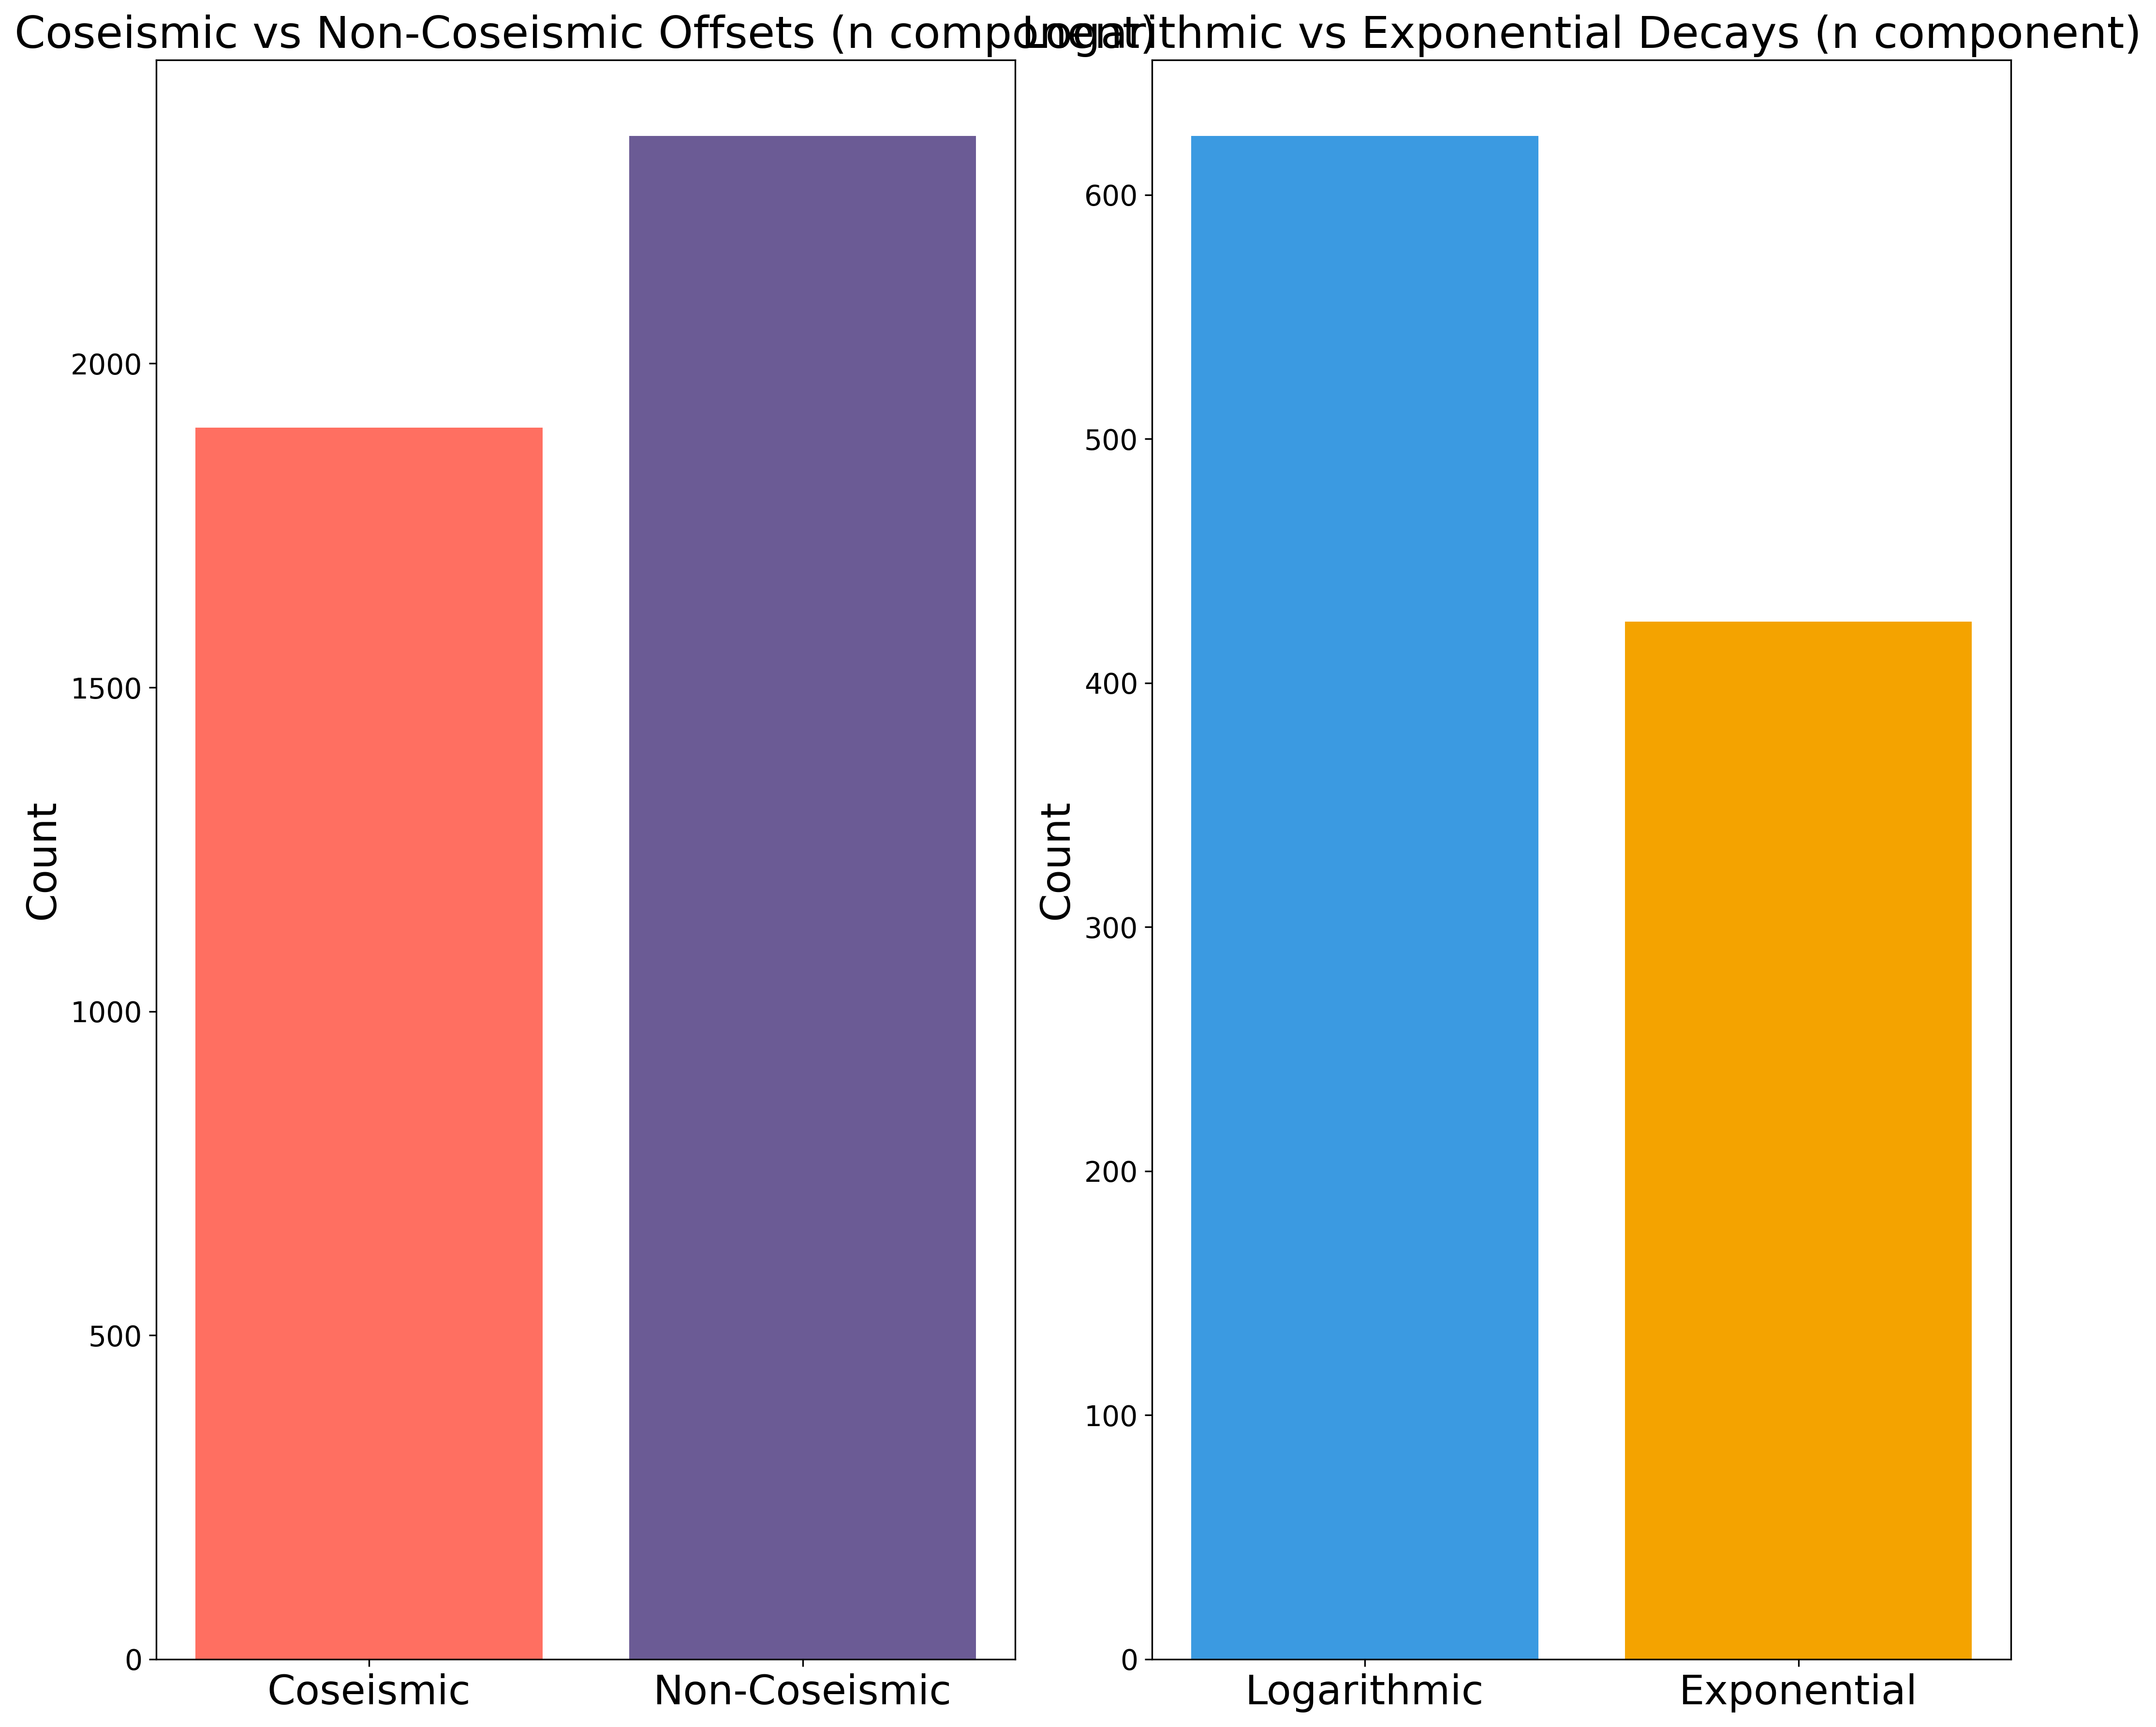

In [112]:
# Analyze and visualize offset and decay data for a specified component ('n').
# Total number of coseismic and non-coseismic offsets, including the total number of logarithmic and exponential decays.

component = 'n'
offsets_data, ps_decays_data = [], []
coseismic_offsets, non_coseismic_offsets = 0, 0
log_decays, exp_decays = 0, 0

for df in dfs:
    for offset in df.attrs['offsets'][component]['offsets']:
        if offset['coseismic']:
            coseismic_offsets += 1
        else:
            non_coseismic_offsets += 1
        offsets_data.append(offset['value'])
    
    for decay in df.attrs['offsets'][component]['ps_decays']:
        if decay['type'] == 'logarithmic':
            log_decays += 1
        else:
            exp_decays += 1
        ps_decays_data.append(decay['value'])
        
print(f'The total number of stations before cleaning is: {len(dfs)}')
print(f"Total number of offsets for {component} component: {len(offsets_data)}")
print(f"Total number of decays for {component} component: {len(ps_decays_data)}")

fig, axs = plt.subplots(1, 2, figsize=subplot_size, dpi=dpi_setting)

axs[0].bar(['Coseismic', 'Non-Coseismic'], [coseismic_offsets, non_coseismic_offsets], color=['#FF6F61', '#6B5B95'])
axs[0].set_title(f'Coseismic vs Non-Coseismic Offsets ({component} component)', fontsize=title_fontsize)
axs[0].set_ylabel('Count', fontsize=label_fontsize)
axs[0].tick_params(axis='y', labelsize=tick_fontsize)
axs[0].tick_params(axis='x', labelsize=label_fontsize)

axs[1].bar(['Logarithmic', 'Exponential'], [log_decays, exp_decays], color=['#3B9AE1', '#F4A300'])
axs[1].set_title(f'Logarithmic vs Exponential Decays ({component} component)', fontsize=title_fontsize)
axs[1].set_ylabel('Count', fontsize=label_fontsize)
axs[1].tick_params(axis='y', labelsize=tick_fontsize)
axs[1].tick_params(axis='x', labelsize=label_fontsize)

plt.tight_layout()
plt.show()

In [113]:
def plot_offsets_by_date(dfs, component, coseismic_only=True):
    """
    This function generates a scatter plot of the total number of offsets by date from the given dataset.
    It filters the offsets to only include coseismic events if coseismic_only=True. 

    Parameters:
    - dfs (list): A list of DataFrames containing the offset data.
    - component (str): The component of interest (e.g., 'n', 'e', 'u').
    - coseismic_only (bool): If True, only coseismic offsets are considered.
    
    Returns:
    - None 
    """

    offset_dates = Counter()

    for df in dfs:
        for offset in df.attrs['offsets'][component]['offsets']:
            if coseismic_only and not offset['coseismic']:
                continue
            offset_dates[offset['date']] += 1

    dates = pd.to_datetime(list(offset_dates.keys()))
    counts = list(offset_dates.values())

    plt.figure(figsize=plot_size)
    plt.scatter(dates, counts, color='dodgerblue', edgecolor='black', alpha=0.7, s=100)

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right', fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.title('Total Amount of Offsets by Date' + (f' (Coseismic only, {component} Component)' if coseismic_only else f' ({component} Component)'),
              fontsize=title_fontsize)
    plt.xlabel('Date', fontsize=label_fontsize)
    plt.ylabel('Total Offsets', fontsize=label_fontsize)
    plt.tight_layout()
    plt.show()

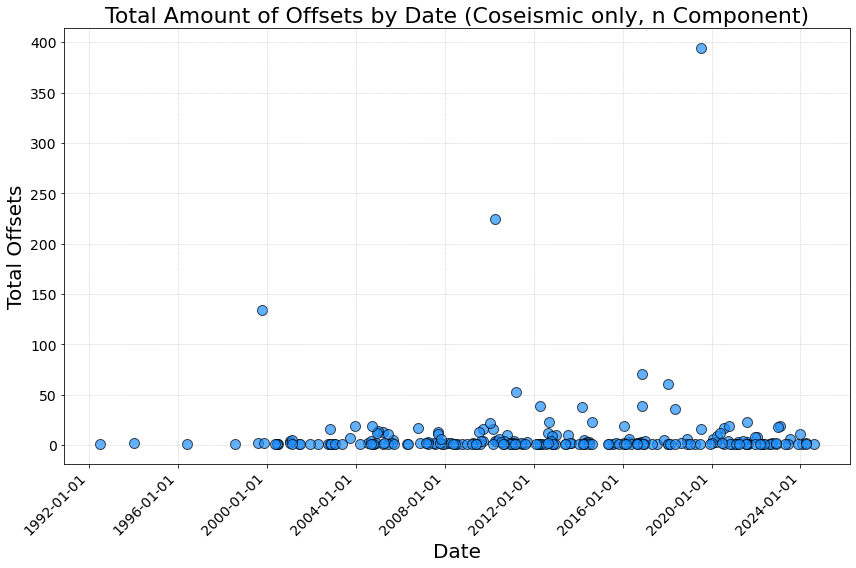

In [114]:
plot_offsets_by_date(dfs, 'n', coseismic_only=True)

In [115]:
def plot_offsets_per_station(dfs, component, coseismic_only=True):
    """
    This function generates a bar plot showing the total number of offsets per station.
    It filters the offsets to include only coseismic events if coseismic_only=True.

    Parameters:
    - dfs (list): A list of DataFrames containing the offset data.
    - component (str): The component of interest (e.g., 'n', 'e', 'u').
    - coseismic_only (bool): If True, only coseismic offsets are considered. 

    Returns:
    - None
    """

    offset_counts = []

    for df in dfs:
        count = 0
        for offset in df.attrs['offsets'][component]['offsets']:
            if coseismic_only and not offset['coseismic']:
                continue
            count += 1
        offset_counts.append(count)

    plt.figure(figsize=plot_size)
    plt.bar(range(len(offset_counts)), offset_counts, color='dodgerblue')

    plt.title('Total Number of Offsets per Station' + (f' (Coseismic only, {component} Component)' if coseismic_only else f' ({component} Component)'),
              fontsize=title_fontsize)
    plt.xlabel('Stations', fontsize=label_fontsize)
    plt.ylabel('Number of Offsets', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

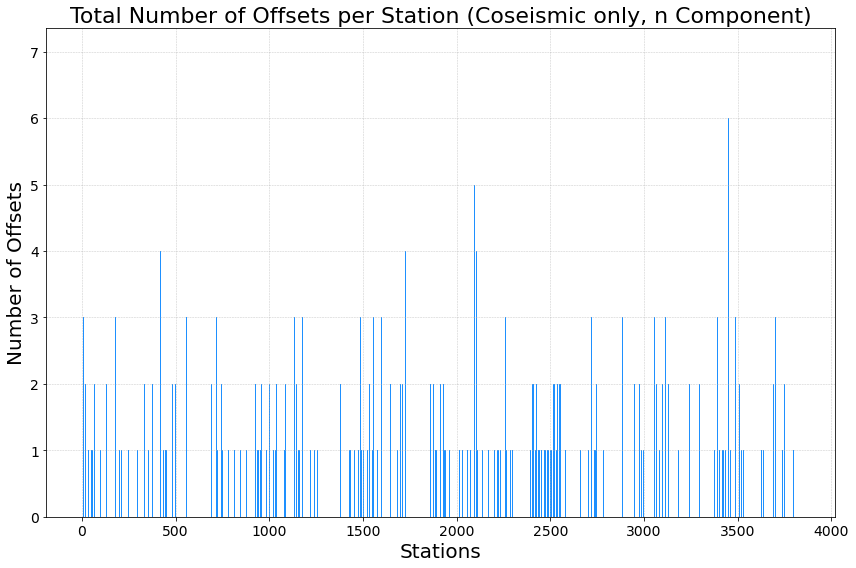

In [116]:
plot_offsets_per_station(dfs, 'n', coseismic_only=True)

In [117]:
def add_missing_dates(df):
    """
    Reindexes a DataFrame to include all dates in the range from the minimum to 
    the maximum date in its datetime index.

    This function ensures that the DataFrame has a continuous daily date range. 
    Missing dates are added with NaN values for all columns, preserving the original 
    structure of the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame, index will be converted to datetime.

    Returns:
    - pd.DataFrame: A new DataFrame reindexed with a complete daily date range. 
      The DataFrame retains its original name, and NaN values are added for missing dates.
    """
    
    df.index = pd.to_datetime(df.index)
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df_full = df.reindex(full_date_range)
    df_full.name = df.name
    return df_full

In [118]:
def plot_unobserved_days(dfs, comp, fill_missing_dates=True):
    """
    Generates a plot showing the number of unobserved days (None values) 
    for the given component across different stations. It optionally fills missing dates 
    between the first and last entry for each station.

    Parameters:
    - dfs (list): A list of DataFrames containing the offset data for each station.
    - comp (str): The component of interest (e.g., 'N', 'E', 'U').
    - fill_missing_dates (bool): If True, the function fills missing dates between the first and last data point 
                                 with None values. If False, it only counts the None values in the existing data.

    Returns:
    - None
    """
    
    none_counts = []

    for df in dfs:
        if fill_missing_dates:
            df_full = add_missing_dates(df)
            none_count = df_full[comp].isna().sum()
        else:
            none_count = df[comp].isna().sum()
        
        none_counts.append(none_count)
    
    print('The total number of unobserved days is' + (' (filled missing dates): ' if fill_missing_dates else ' (original data): ') + str(sum(none_counts)))
    
    plt.figure(figsize=(12, 8))
    if fill_missing_dates:
        plt.bar(range(len(none_counts)), none_counts, color='dodgerblue', alpha=0.7)
    else:
        plt.scatter(range(len(none_counts)), none_counts, color='dodgerblue', s=100)

    plt.title(f'Number of Unobserved Days for {comp} Component Across Stations ' + 
              ('(Filled Missing Dates)' if fill_missing_dates else '(Original Data)'), fontsize=title_fontsize)
    plt.xlabel('Stations', fontsize=label_fontsize)
    plt.ylabel(f'Count of None Values in {comp} Component', fontsize=label_fontsize)

    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

The total number of unobserved days is (filled missing dates): 1887528


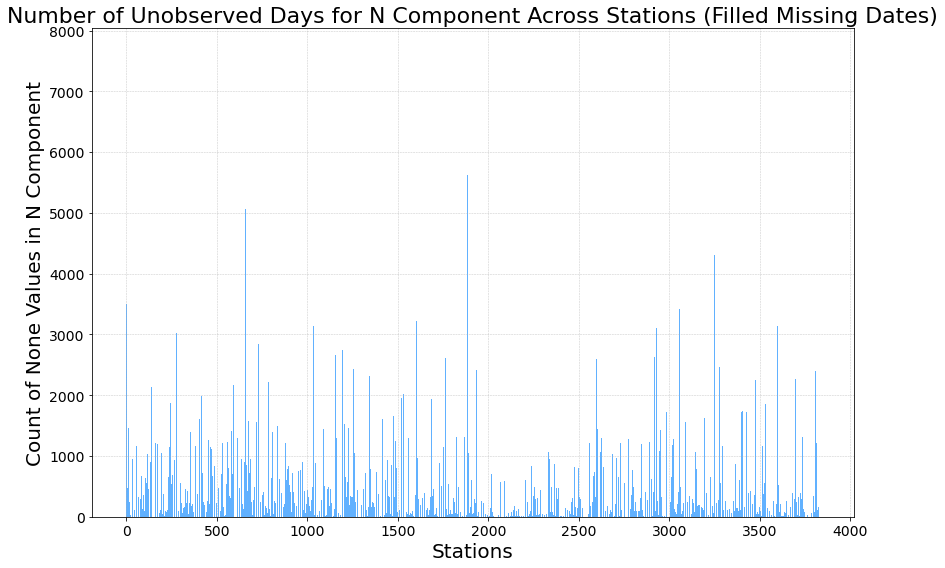

In [119]:
plot_unobserved_days(dfs, 'N', fill_missing_dates=True)